## Movie Data Analysis

Please fill out:
* Student name: Yue Yu, Margaret Boland, Peter Burton 
* Student pace: full time
* Scheduled project review date/time: June 3rd 2022
* Instructor name: 
* Blog post URL:


In [1]:
import pandas as pd
import numpy as np
import sqlite3
import zipfile
import matplotlib.pyplot as plt

In [2]:
# upzip im.db.zip file
with zipfile.ZipFile('./zippedData/im.db.zip') as zipObj:
    zipObj.extractall(path='./zippedData/')

In [3]:
con = sqlite3.connect('zippedData/im.db')
cursor = con.cursor()

In [4]:
# check table names
schema_df = pd.read_sql("""
                        SELECT 
                            *
                        FROM 
                            sqlite_master """, con)
schema_df

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


We think genres, director and runtime of the movie have large impact on the profitability of a movie. So, we are going to make a table that contains all these information first.

## Make a clean budget table

In [5]:
df_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
df_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [6]:
"""All the numbers in this table need to be converted to integers"""

df_budgets['budgets(USD)'] = df_budgets['production_budget'].str.replace('$','').str.replace(',', '').astype(int)
df_budgets['dom_gross(USD)'] = df_budgets['domestic_gross'].str.replace('$','').str.replace(',', '').astype(int)
df_budgets['world_gross(USD)'] = df_budgets['worldwide_gross'].str.replace('$','').str.replace(',', '').astype('int64')

In [7]:
# keep the int columns only
budget_clean = df_budgets.drop(['production_budget','domestic_gross','worldwide_gross'], axis=1)
budget_clean.head()

,id,release_date,movie,budgets(USD),dom_gross(USD),world_gross(USD)
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


We are going to work with data from the SQL database. The next step is to put together all the data we need from the database with the budget table above.

## Join movie_basics and budget_clean

In [8]:
df_basics = pd.read_sql("""
                        SELECT 
                            movie_id, 
                            primary_title AS movie, 
                            genres, 
                            runtime_minutes
                        FROM 
                            movie_basics """, con)

In [9]:
# we want all the movies' name and movie id to be shown in the table.
movie_budget = budget_clean.merge(df_basics, on='movie')
movie_budget.head()

,id,release_date,movie,budgets(USD),dom_gross(USD),world_gross(USD),movie_id,genres,runtime_minutes
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,tt1775309,Horror,93.0
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,tt1298650,"Action,Adventure,Fantasy",136.0
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,tt6565702,"Action,Adventure,Sci-Fi",113.0
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,tt2395427,"Action,Adventure,Sci-Fi",141.0
4,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,tt4154756,"Action,Adventure,Sci-Fi",149.0


## Calculate profit of each movie

In [10]:
# add a new column that shows the profit of each movie
movie_budget['Estimated Profit'] = movie_budget['world_gross(USD)']-movie_budget['budgets(USD)']
movie_budget.head()

,id,release_date,movie,budgets(USD),dom_gross(USD),world_gross(USD),movie_id,genres,runtime_minutes,Estimated Profit
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,tt1775309,Horror,93.0,2351345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,tt1298650,"Action,Adventure,Fantasy",136.0,635063875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,tt6565702,"Action,Adventure,Sci-Fi",113.0,-200237650
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,tt2395427,"Action,Adventure,Sci-Fi",141.0,1072413963
4,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,tt4154756,"Action,Adventure,Sci-Fi",149.0,1748134200


## Make the final table include all the data we need

In [11]:
df_directors = pd.read_sql("""
                        SELECT 
                            *
                        FROM 
                            directors """, con)
df_directors.head()

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502


In [12]:
df_person = pd.read_sql("""
                        SELECT 
                            *
                        FROM 
                            persons """, con)
df_person.head()

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


In [13]:
director_df = pd.read_sql("""
                            SELECT
                                d.movie_id, 
                                p.primary_name AS director_name
                            FROM 
                                directors AS d
                                INNER JOIN persons AS p
                                    ON d.person_id = p.person_id
                                """, con)
director_df.head()

,movie_id,director_name
0,tt0285252,Tony Vitale
1,tt0462036,Bill Haley
2,tt0835418,Jay Chandrasekhar
3,tt0835418,Jay Chandrasekhar
4,tt0878654,Albert Pyun


In [14]:
# add director names to the table
movie_df = movie_budget.merge(director_df, on='movie_id', how='inner')
movie_clean_df = movie_df.drop_duplicates(subset='movie',keep='first')
movie_clean_df.head()

,id,release_date,movie,budgets(USD),dom_gross(USD),world_gross(USD),movie_id,genres,runtime_minutes,Estimated Profit,director_name
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,tt1775309,Horror,93.0,2351345279,Atsushi Wada
2,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,tt1298650,"Action,Adventure,Fantasy",136.0,635063875,Rob Marshall
7,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,tt6565702,"Action,Adventure,Sci-Fi",113.0,-200237650,Simon Kinberg
13,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,tt2395427,"Action,Adventure,Sci-Fi",141.0,1072413963,Joss Whedon
18,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,tt4154756,"Action,Adventure,Sci-Fi",149.0,1748134200,Anthony Russo


## The most popular genres of top 100 profitable movies

In [34]:
most_profit_movie = movie_clean_df.sort_values(by=['Estimated Profit'],ascending=False)[:100]
most_profit_movie['genres'].value_counts().head(10)

Action,Adventure,Sci-Fi       25
Adventure,Animation,Comedy    15
Action,Adventure,Fantasy       8
Action,Adventure,Comedy        7
Action,Adventure,Animation     5
Adventure,Family,Fantasy       4
Action,Crime,Thriller          3
Adventure,Drama,Fantasy        2
Adventure,Fantasy              2
Animation,Comedy,Family        2
Name: genres, dtype: int64

In [15]:
most_profit_movie = movie_clean_df.sort_values(by=['Estimated Profit'],ascending=False)[:100]
profit_genres = movie_clean_df.sort_values(by=['Estimated Profit'], ascending=False)['genres'][:100]
pop_gen_ls = ['Act,Adv,Sci','Adv,Anim,Com','Act,Adv,Fan','Act,Adv,Com','Act,Adv,Anim','Adv,Fam,Fan','Act,Crim,Thri','Anim,Com, Fam',
             'Act,Adv,Thri','Adv,Dram,Sci']

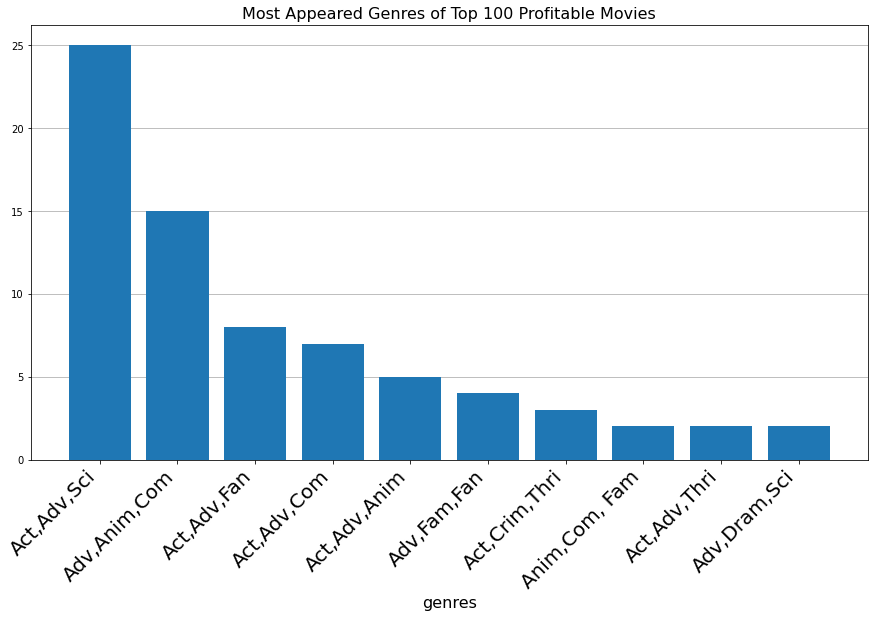

In [16]:
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(x=profit_genres.value_counts()[:10].index, height=profit_genres.value_counts()[:10], zorder=3)
ax.set_xlabel('genres', fontsize=16)
plt.xticks(np.arange(0,10),fontsize=20,rotation=45,labels=pop_gen_ls,ha='right')
ax.set_title('Most Appeared Genres of Top 100 Profitable Movies', fontsize=16)
ax.grid(axis='y', zorder=0)
plt.show();

##  Average budget of each genre

In [20]:
genres = profit_genres.value_counts()[:10].index
top_profit_movie_genres = movie_clean_df.loc[movie_clean_df['genres'].isin(genres)]
profit_genres_ls = top_profit_movie_genres.groupby('genres')
mean_budgets = profit_genres_ls.mean()['budgets(USD)']
mean_budgets

genres
Action,Adventure,Animation    1.151471e+08
Action,Adventure,Comedy       8.505000e+07
Action,Adventure,Fantasy      1.415886e+08
Action,Adventure,Sci-Fi       1.649164e+08
Action,Crime,Thriller         5.904167e+07
Adventure,Animation,Comedy    9.811029e+07
Adventure,Drama,Fantasy       4.191000e+07
Adventure,Family,Fantasy      1.354000e+08
Adventure,Fantasy             2.316667e+08
Animation,Comedy,Family       5.521429e+07
Name: budgets(USD), dtype: float64

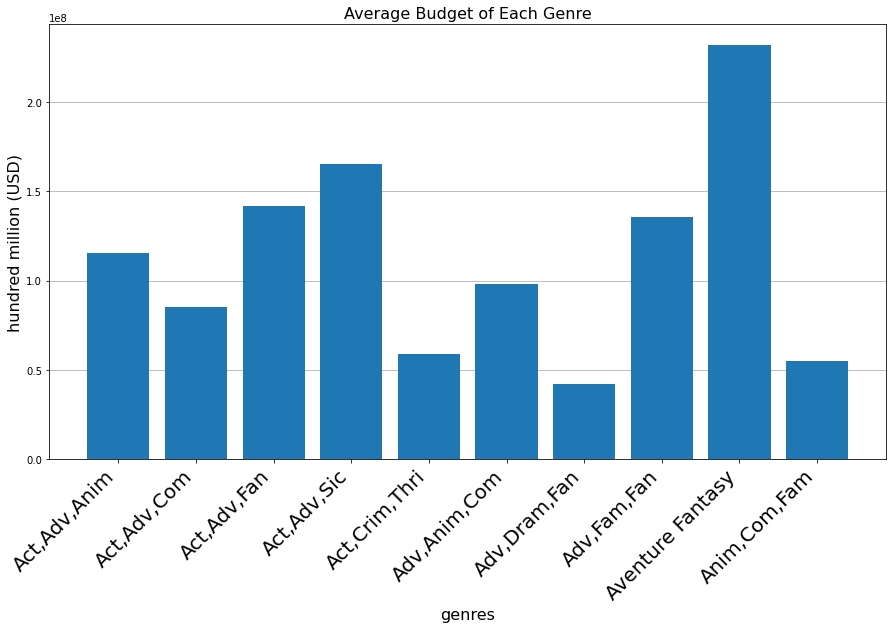

In [24]:
gen_ls = ['Act,Adv,Anim','Act,Adv,Com','Act,Adv,Fan','Act,Adv,Sic','Act,Crim,Thri','Adv,Anim,Com',
         'Adv,Dram,Fan','Adv,Fam,Fan','Aventure Fantasy','Anim,Com,Fam']
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(x=mean_budgets.index, height=mean_budgets, zorder=3)
ax.set_xlabel('genres', fontsize=16)

ax.set_ylabel('hundred million (USD)',fontsize=16)
plt.xticks(np.arange(0,10),fontsize=20,rotation=45,labels=gen_ls,ha='right')

ax.set_title('Average Budget of Each Genre', fontsize=16)
ax.grid(axis='y', zorder=0)
plt.show();